In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [2]:
DATASET_SIZE = 70000
TRAIN_RATIO = 0.7
VALIDATION_RATIO = 0.2
TEST_RATIO = 0.1

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

x_train_orig, x_valid_orig, y_train_orig, y_valid_orig = train_test_split(x, y, test_size=(1-TRAIN_RATIO))
x_valid_orig, x_test_orig, y_valid_orig, y_test_orig = train_test_split(x_valid_orig, y_valid_orig, test_size=((TEST_RATIO/(VALIDATION_RATIO+TEST_RATIO))))

In [3]:
# change the format of data 
def data_format(y): 
    y_10 = []
    for i in np.arange(10): 
        temp = (y==i).astype(int)
        y_10 = np.append(y_10, temp)
        #print(y_10)
    y_10 = y_10.reshape(y.shape[0], -1, order='F')
    return y_10 

# normalize data 
x_train = x_train_orig.reshape(x_train_orig.shape[0], -1).astype('float32')/255.
y_train = data_format(y_train_orig)

x_valid = x_valid_orig.reshape(x_valid_orig.shape[0], -1).astype('float32')/255.
y_valid = data_format(y_valid_orig)

x_test = x_test_orig.reshape(x_test_orig.shape[0], -1).astype('float32')/255.
y_test = data_format(y_test_orig)

In [4]:
# minimization function 
def min_fun(x, y, w, lambda_): 
    N = np.shape(x)[0]
    K = np.shape(w)[0]
    I = np.identity(K)
    one = np.ones(N)
    x_ = np.c_[x, one]
    S = np.cos(x_.dot(w.T)) 
    beta = np.linalg.inv(np.dot(S.T, S) + lambda_ * N * I).dot(S.T).dot(y)
    return beta, S

In [5]:
def error_compute(y, pred):
    #error = - np.sum(np.diagonal(y.dot(np.log(pred+1e-10).T)))
    # y pred in N*10
    #error = np.mean(np.sum((y-pred)**2, axis=1))
    N = np.shape(y)[0]
    y_index = np.argmax(y, 1)
    pred_index = np.argmax(pred, 1)
    error = np.linalg.norm((y_index-pred_index), ord=2)/N
    return error

In [6]:
def accuracy_compute(y, pred): 
    y_index = np.argmax(y, 1)
    pred_index = np.argmax(pred, 1)
    accuracy = np.mean((pred_index==y_index).astype('int'))
    return accuracy

In [7]:
def training(x_train, y_train, x_valid, y_valid, x_test, y_test, 
             K, w_combine, lambda_): 
    
    N = np.shape(x_train)[0]
    
    beta = np.zeros(10*K).reshape(10, K)
    S = np.zeros(10*N*K).reshape(10, N, K)
    for i in np.arange(10): 
        beta[i],  S[i] = min_fun(x_train, y_train[:,i], w_combine, lambda_)


    pred_train = np.zeros(10*N).reshape(N, 10)
    for i in np.arange(10): 
        pred_train[:,i] = S[i].dot(beta[i])
    error_train = error_compute(y_train, pred_train)
    accuracy_train = accuracy_compute(y_train, pred_train)
        
        
    N_valid = np.shape(x_valid)[0]
    beta_valid = np.zeros(10*K).reshape(10, K)
    S_valid = np.zeros(10*N_valid*K).reshape(10, N_valid, K)
    for i in np.arange(10): 
        beta_valid[i],  S_valid[i] = min_fun(x_valid, y_valid[:,i], w_combine, lambda_)
    pred_valid = np.zeros(10*N_valid).reshape(N_valid, 10)
    for i in np.arange(10): 
        pred_valid[:,i] = S_valid[i].dot(beta[i])
    error_valid= error_compute(y_valid, pred_valid)
    accuracy_valid= accuracy_compute(y_valid, pred_valid)


    N_test = np.shape(x_test)[0]
    beta_test = np.zeros(10*K).reshape(10, K)
    S_test = np.zeros(10*N_test*K).reshape(10, N_test, K)
    for i in np.arange(10): 
        beta_test[i],  S_test[i] = min_fun(x_test, y_test[:,i], w_combine, lambda_)
    pred_test = np.zeros(10*N_test).reshape(N_test, 10)
    for i in np.arange(10): 
        pred_test[:,i] = S_test[i].dot(beta[i])
    error_test = error_compute(y_test, pred_test)
    accuracy_test = accuracy_compute(y_test, pred_test)

    print("\n for k=" + str(K))
    print("\n Training error " + str(error_train) + ",Accuracy " + str(accuracy_train)) 
    print("\n Validation error " + str(error_valid) + ", Validation accuracy " + str(accuracy_valid)) 
    
    return error_train, error_valid, error_test, accuracy_train, accuracy_valid, accuracy_test

In [8]:
d = 784
lambda_ = 0.1
delta = 0.1
gamma = 3*d - 2

N = np.shape(x_train)[0]
d = np.shape(x_train)[1] 

K = np.arange(0,11) 
K = 2**K

error_train_list = []
error_valid_list = []
error_test_list = []
    
accuracy_train_list = []
accuracy_valid_list = []
accuracy_test_list = []

for k in K: 
    b = np.random.normal(0, 0.1, k*1)
    w = np.random.normal(0, 0.1, k*d)
    w_combine = np.append(w,b).reshape((k, d+1), order='F')
    
    error_train, error_valid, error_test, accuracy_train, accuracy_valid, accuracy_test = training(x_train, y_train, x_valid, y_valid, x_test, y_test, 
                                                                                                   k, w_combine, lambda_)
    
    error_train_list = np.append(error_train_list, error_train)
    error_valid_list = np.append(error_valid_list, error_valid)
    error_test_list = np.append(error_test_list, error_test)
    
    accuracy_train_list = np.append(accuracy_train_list, accuracy_train)
    accuracy_valid_list = np.append(accuracy_valid_list, accuracy_valid)
    accuracy_test_list = np.append(accuracy_test_list, accuracy_test)
  


 for k=1

 Training error 0.021564057304219394,Accuracy 0.17137084430294497

 Validation error 0.04021149444766118, Validation accuracy 0.17564285714285716

 for k=2

 Training error 0.018856091981502343,Accuracy 0.14586011959427744

 Validation error 0.03528462982717569, Validation accuracy 0.14557142857142857

 for k=4

 Training error 0.01741080329087627,Accuracy 0.25247454029674077

 Validation error 0.03234925794814957, Validation accuracy 0.2551428571428571

 for k=8

 Training error 0.017381329733314355,Accuracy 0.29586318088124247

 Validation error 0.03273572285776516, Validation accuracy 0.29114285714285715

 for k=16

 Training error 0.014908994836830433,Accuracy 0.43141696769321825

 Validation error 0.02773756386165865, Validation accuracy 0.43614285714285717

 for k=32

 Training error 0.01166215964993063,Accuracy 0.5956244004979694

 Validation error 0.021907621448962012, Validation accuracy 0.5997857142857143

 for k=64

 Training error 0.010083676661973063,Accuracy 0.

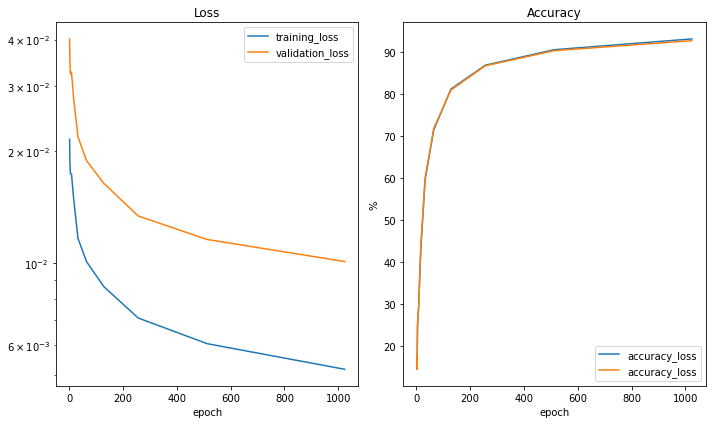

In [9]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2,  1)
plt.semilogy(K, error_train_list, label = 'training_loss')
plt.semilogy(K, error_valid_list, label = 'validation_loss')
plt.legend()
plt.xlabel('epoch')
plt.title('Loss')
    
plt.subplot(1, 2, 2)
plt.plot(K, accuracy_train_list*100, label = 'accuracy_loss')
plt.plot(K, accuracy_valid_list*100, label = 'accuracy_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('%')
plt.title('Accuracy')
plt.tight_layout()
plt.show()

In [10]:
accuracy_table = np.append(K, accuracy_valid_list*100).reshape((11,2), order='F')
np.set_printoptions(precision=3, suppress=True)
print(accuracy_table)

[[   1.      17.564]
 [   2.      14.557]
 [   4.      25.514]
 [   8.      29.114]
 [  16.      43.614]
 [  32.      59.979]
 [  64.      71.779]
 [ 128.      80.943]
 [ 256.      86.7  ]
 [ 512.      90.3  ]
 [1024.      92.671]]
